随机森林分类在乳腺癌数据上的调参

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
data = load_breast_cancer()

In [4]:
data.data.shape

(569, 30)

In [10]:
# 建模
rfc = RandomForestClassifier(n_estimators=100, random_state=90)
score_pre = cross_val_score(rfc, data.data, data.target, cv = 10).mean()

In [23]:
score_pre

0.6344463971880492

0.9631265664160402 71


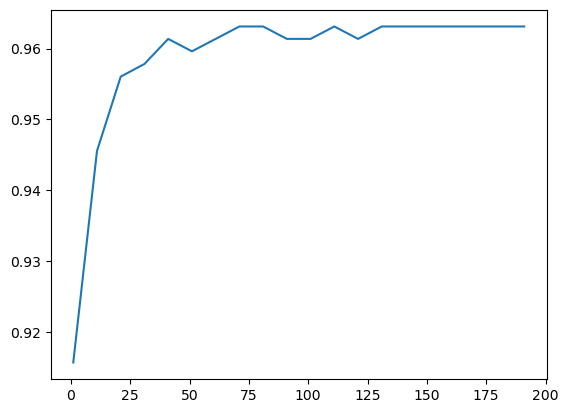

In [26]:
'''
随机森林调参第一步：n_estimators
使用学习曲线，看见n_estimators在什么取值开始变得平稳，是否一直推动模型准确率的上升
'''
scorel = []
for i in range(0, 200, 10):
    rfc = RandomForestClassifier(n_estimators=i+1, n_jobs=-1, random_state=90)
    score = cross_val_score(rfc, data.data, data.target, cv = 10).mean()
    scorel.append(score)

print(max(scorel), (scorel.index(max(scorel))*10)+1)
plt.figure()
plt.plot(range(1, 201, 10), scorel)
plt.show()

0.9666353383458647 73


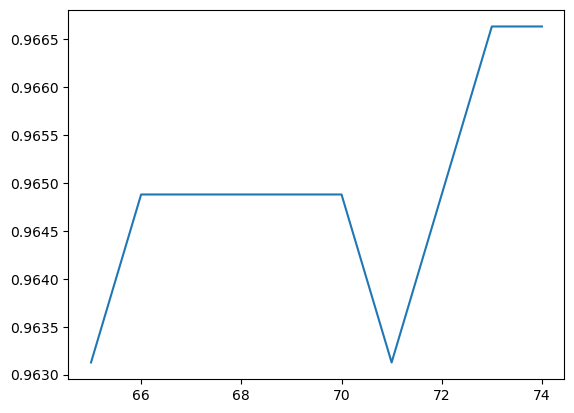

In [ ]:
# 确定好范围之后，进一步细化学习曲线
scorel = []
for i in range(65, 75):
    rfc = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=90)
    score = cross_val_score(rfc, data.data, data.target, cv = 10).mean()
    scorel.append(score)

print(max(scorel), ([*range(65, 75)][scorel.index(max(scorel))]))
plt.figure()
plt.plot(range(65, 75), scorel)
plt.show()
 
# n_estimators = 73

In [29]:
# 使用网格搜索 
'''
有一些参数是没有参照的，很难说清一个区间，这种情况下我们使用学习曲线，看趋势
从曲线跑出的结果去选取一个更小的区间，再跑曲线
有一些参数是可以找到一个范围的，这样可以直接网格搜索
max_depth min_leaf
'''
# 首先调整max_depth
# 一般根据数据大小来进行一个试探，乳腺癌数据很小，所以可以采用1-10或者1-20这样的试探
# 但对于大型数据集，我们应该尝试30-50的深度，甚至更深
# 更应该画出学习曲线，来观察深度对于模型的影响
param_grid = {'max_depth': np.arange(1, 20, 1)}

rfc = RandomForestClassifier(n_estimators=73, random_state=90)

GS = GridSearchCV(rfc, param_grid, cv = 10)
GS.fit(data.data, data.target)


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=73, random_state=90),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [ ]:
GS.best_params_

{'max_depth': 8}

In [33]:
GS.best_score_


0.9666353383458647

In [ ]:
# 发现max_depth并不增加score，说明此时模型处于：增加复杂度误差会下降，而简单化模型会使模型准确率下降 
# 我们需要增加复杂度，而max_depth, min_leaf都是剪枝参数，作用就是简单化模型，因此我们不应该调整这几个参数
# min_sample_leaf/split 一般是用最小值，往上加10/50/200
# 下面我们调整max_features
param_grid = {'max_features':np.arange(5, 30, 1)}
# max_features 是唯一一个既能够像左推（低方差高偏差），又能像右（高方差低偏差）的参数
# 现在模型位于左侧，我们需要更高的复杂度，因此要将max_features调大
# max_features默认的最小值为sqrt（n_features）

rfc = RandomForestClassifier(n_estimators=73, random_state=90)

GS = GridSearchCV(rfc, param_grid, cv = 10)
GS.fit(data.data, data.target)


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=73, random_state=90),
             param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29])})

In [12]:
GS.best_params_

{'max_features': 24}

In [13]:
GS.best_score_

0.9666666666666668

In [ ]:
# 发现max_features增大，模型复杂度升高，模型效果更好了
# 模型已经达到了最佳复杂度，既在尽可能低的复杂度下达到尽可能精确的效果

In [14]:
# 调整criterion
param_grid = {'criterion':['gini', 'entropy']}

rfc = RandomForestClassifier(n_estimators=73, max_features=24, random_state=90)

GS = GridSearchCV(rfc, param_grid, cv = 10)
GS.fit(data.data, data.target)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_features=24, n_estimators=73,
                                              random_state=90),
             param_grid={'criterion': ['gini', 'entropy']})

In [15]:
GS.best_params_

{'criterion': 'gini'}

In [18]:
score = GS.best_score_

In [19]:
score - score_pre

0.0017857142857143904